# **NYC TAXI**

In [1]:
#from google.colab import files
#uploaded = files.upload()

Saving requirements.txt to requirements.txt


In [2]:
#from google.colab import files
#uploaded = files.upload()

Saving train.csv to train.csv


In [3]:
#from google.colab import files
#uploaded = files.upload()

Saving test.csv to test.csv


In [24]:
#from google.colab import files
#uploaded = files.upload()

Saving weather_data_nyc_centralpark_2016(1).csv to weather_data_nyc_centralpark_2016(1).csv


In [5]:
%pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 kB 2.2 MB/s eta 0:00:00


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

In [ ]:
# 1. Load data
trainFull = pd.read_csv('train.csv')
testFull = pd.read_csv('test.csv')

weather = pd.read_csv("weather_data_nyc_centralpark_2016(1).csv")
weather.columns = [col.lower().strip().replace(" ", "_") for col in weather.columns]

weather.rename(columns={
    'maximum_temperature': 'max_temp',
    'minimum_temperature': 'min_temp',
    'average_temperature': 'avg_temp',
    'precipitation': 'precip',
    'snow_fall': 'snowfall',
    'snow_depth': 'snow_depth'
}, inplace=True)

weather['date'] = pd.to_datetime(weather['date'], dayfirst=True)

for col in ['precip', 'snowfall']:
    weather[col] = weather[col].replace('T', 0).astype(float)

# Convert datetime
trainFull['pickup_datetime'] = pd.to_datetime(trainFull['pickup_datetime'])
testFull['pickup_datetime'] = pd.to_datetime(testFull['pickup_datetime'])

# Convert pickup_datetime to datetime
trainFull['pickup_datetime'] = pd.to_datetime(trainFull['pickup_datetime'])
testFull['pickup_datetime'] = pd.to_datetime(testFull['pickup_datetime'])

# Convert to normalized datetime (keeps datetime64[ns])
trainFull['pickup_date'] = trainFull['pickup_datetime'].dt.normalize()
testFull['pickup_date'] = testFull['pickup_datetime'].dt.normalize()

# Ensure weather date is the same dtype
weather['date'] = pd.to_datetime(weather['date']).dt.normalize()

# merge dataset
train = trainFull.merge(weather, left_on='pickup_date', right_on='date', how='left')
test = testFull.merge(weather, left_on='pickup_date', right_on='date', how='left')

# Drop duplicate column
train.drop(columns=['date'], inplace=True)
test.drop(columns=['date'], inplace=True)

# Merge weather INTO trainFull
train = trainFull.merge(weather, left_on='pickup_date', right_on='date', how='left')
test = testFull.merge(weather, left_on='pickup_date', right_on='date', how='left')

train.drop(columns=['date'], inplace=True)
test.drop(columns=['date'], inplace=True)

# 4. NOW create engineered features on merged dataframe
train = create_datetime_features(train)
train = create_geo_features(train)

test = create_datetime_features(test)
test = create_geo_features(test)


In [56]:
train.shape
train.columns


Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'max_temp', 'min_temp', 'avg_temp',
       'precip', 'snowfall', 'snow_depth', 'pickup_hour', 'pickup_day',
       'pickup_dayofweek', 'pickup_month', 'pickup_hour_sin',
       'pickup_hour_cos', 'pickup_dayofweek_sin', 'pickup_dayofweek_cos',
       'haversine_distance', 'street_distance', 'dropoff_distance_from_center',
       'pickup_distance_from_center'],
      dtype='object')

###Checking for missing values

In [32]:
# Check for missing values in each column
missing_counts = trainFull.isnull().sum()

# Display columns that have missing values (if any)
print("Missing values per column:")
print(missing_counts[missing_counts > 0])

if trainFull.isnull().values.any():
    print("\nThe dataset contains missing values.")
else:
    print("\nThe dataset has no missing values.")


Missing values per column:
Series([], dtype: int64)

The dataset has no missing values.


### Consistency check : **trip times**

In [ ]:
import pandas as pd
import numpy as np

def check_duration_consistency(data, tolerance=1):
    # Ensure datetimes are actually datetime objects
    # (pickup_datetime is already converted in your create_datetime_features, but dropoff might not be)
    pickup = pd.to_datetime(data['pickup_datetime'])
    dropoff = pd.to_datetime(data['dropoff_datetime'])

    # Calculate duration in seconds
    calculated_duration = (dropoff - pickup).dt.total_seconds()

    # Calculate the absolute difference
    diff = np.abs(data['trip_duration'] - calculated_duration)

    # Find inconsistencies
    inconsistent_mask = diff > tolerance
    num_inconsistent = inconsistent_mask.sum()

    if num_inconsistent == 0:
        print("All trip_duration values are consistent with timestamps.")
    else:
        print(f"Found {num_inconsistent} records with inconsistent durations (diff > {tolerance}s).")

        # Show some examples of inconsistent rows
        bad_rows = data[inconsistent_mask].copy()
        bad_rows['calculated_duration'] = calculated_duration[inconsistent_mask]
        bad_rows['diff'] = diff[inconsistent_mask]

        print("\nTop 5 biggest inconsistencies:")
        cols_to_show = ['pickup_datetime', 'dropoff_datetime', 'trip_duration', 'calculated_duration', 'diff']
        print(bad_rows.sort_values('diff', ascending=False)[cols_to_show].head())

# Run the check on your trainFull dataset
check_duration_consistency(trainFull)

#**Feature Visualizations**

###Plotting pickup coordinates

In [34]:
%pip install plotly
import plotly.express as px

# Sample the data (full dataset is too large to plot)
sample = trainFull.sample(n=10000, random_state=42)

# Plot pickups
fig = px.scatter_mapbox(
    sample,
    lat='pickup_latitude',
    lon='pickup_longitude',
    size_max=5,
    zoom=10,
    center={'lat': 40.7128, 'lon': -74.0060},
    mapbox_style='carto-positron',
    title='NYC Taxi Pickups',
    opacity=0.5
)
fig.show()

####Most pickups are coming from Manhattan, other notable pickup spots are from JFK airport

##Date/time vs trip duration

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
# Convert trip_duration from seconds to minutes
trainFull['trip_duration_min'] = trainFull['trip_duration'] / 60

# Map day of week numbers to day names
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
trainFull['day_name'] = trainFull['pickup_dayofweek'].map({i: day_names[i] for i in range(7)})

# Calculate median trip duration by day of week and vendor_id
median_duration = trainFull.groupby(['day_name', 'vendor_id'])['trip_duration_min'].median().reset_index()
median_duration = median_duration.sort_values(['day_name', 'vendor_id'])

# Ensure correct order of days
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
median_duration['day_name'] = pd.Categorical(median_duration['day_name'], categories=day_order, ordered=True)
median_duration = median_duration.sort_values('day_name')

# Create the visualization
fig, ax = plt.subplots(figsize=(10, 6))

# Separate data by vendor_id
vendor_1 = median_duration[median_duration['vendor_id'] == 1]
vendor_2 = median_duration[median_duration['vendor_id'] == 2]

# Plot scatter points
ax.scatter(vendor_1['day_name'], vendor_1['trip_duration_min'],
           color='coral', s=100, label='vendor_id 1', zorder=3)
ax.scatter(vendor_2['day_name'], vendor_2['trip_duration_min'],
           color='teal', s=100, label='vendor_id 2', zorder=3)

# Styling to match the image
ax.set_xlabel('Day of the week', fontsize=12)
ax.set_ylabel('Median trip duration [min]', fontsize=12)
ax.set_facecolor('lightgrey')
ax.grid(True, color='white', linestyle='-', linewidth=1)
ax.set_axisbelow(True)
ax.legend(title='vendor_id', fontsize=10, title_fontsize=11)

# Set y-axis limits and ticks to match the style
ax.set_ylim(bottom=9.5, top=12.5)
ax.set_yticks([10.0, 10.5, 11.0, 11.5, 12.0])

plt.tight_layout()
plt.show()

KeyError: 'pickup_dayofweek'

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Calculate median duration per hour and vendor
summary_data = trainFull.groupby(['pickup_hour', 'vendor_id'])['trip_duration_min'].median().reset_index()

fig, ax = plt.subplots(figsize=(10, 6))

colors = {1: 'coral', 2: 'teal'}

# Add SMOOTHING curves
for vendor in [1, 2]:
    subset = summary_data[summary_data['vendor_id'] == vendor]
    if not subset.empty:
        sns.regplot(
            data=subset,
            x='pickup_hour',
            y='trip_duration_min',
            scatter=False,
            lowess=True,
            color=colors[vendor],
            ax=ax
        )

# Add POINTS
sns.scatterplot(
    data=summary_data,
    x='pickup_hour',
    y='trip_duration_min',
    hue='vendor_id',
    palette=colors,
    s=250,
    ax=ax,
    zorder=3
)

# 3. Styling
ax.set_xlabel("Hour of the day", fontsize=12)
ax.set_ylabel("Median trip duration [min]", fontsize=12)
ax.set_title("Median Trip Duration by Hour", fontsize=14)
ax.set_xticks(range(0, 25, 4))
ax.set_facecolor('lightgrey')
ax.grid(True, color='white', linestyle='-', linewidth=1)
ax.set_axisbelow(True)

# Remove legend if desired
ax.get_legend()

plt.tight_layout()
plt.show()

KeyError: 'pickup_hour'

#####There is a pattern for days of the week and hour of days. Seems that trip duration tend to be quicker towards quieter hours in the day and quiter days in the week.

##Date/time vs trip duration

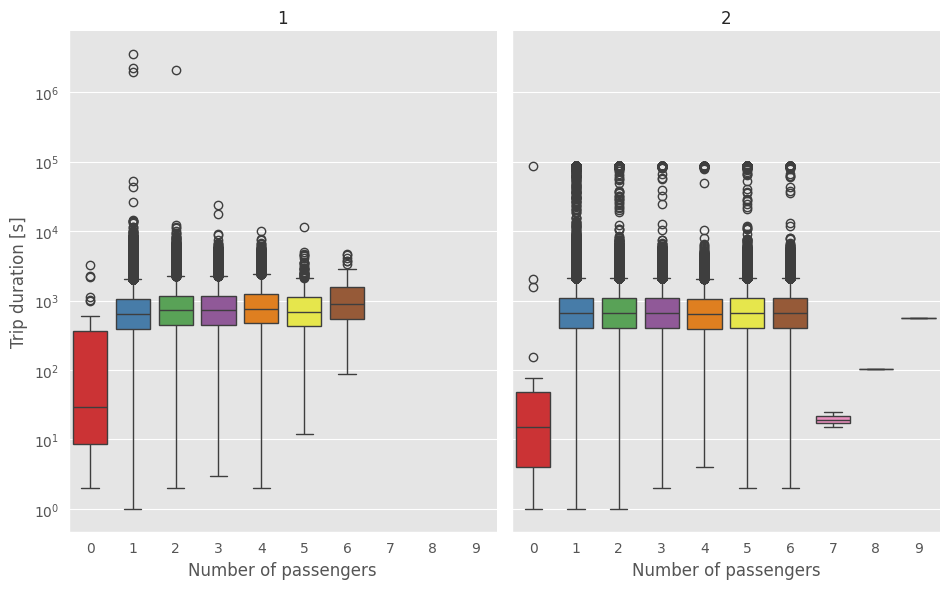

In [37]:
sns.set_style("whitegrid")
plt.style.use('ggplot')

# Create a FacetGrid for the two vendors
g = sns.FacetGrid(trainFull, col='vendor_id', height=6, aspect=0.8)

# Map boxplot to each facet with different colors per passenger_count
g.map_dataframe(
    sns.boxplot,
    x='passenger_count',
    y='trip_duration',
    hue='passenger_count',
    palette='Set1',
    legend=False
)

# Set log scale on y-axis
for ax in g.axes.flat:
    ax.set_yscale('log')

# Labels
g.set_axis_labels('Number of passengers', 'Trip duration [s]')
g.set_titles(col_template='{col_name}')

plt.tight_layout()
plt.show()

#####Without any passengers both vendors have short trips.
#####Vendor 1 has trip_durations beyond 24 hours which we will remove during cleaning. Vendor 2 has all (five) trips iwht more than 6 passengers and more trip durations that approach the 24 hour limit

## Create features

In [48]:
def create_datetime_features(data):
    data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])

    #Extract time features
    data['pickup_hour'] = data['pickup_datetime'].dt.hour
    data['pickup_day'] = data['pickup_datetime'].dt.day
    data['pickup_dayofweek'] = data['pickup_datetime'].dt.dayofweek
    data['pickup_month'] = data['pickup_datetime'].dt.month

    #Pretty cool thing here cuz you map the time and day to a circle so the model understands
    #That 12AM (hour 0) and 11PM (23) are not far apart for example
    data['pickup_hour_sin'] = np.sin(2 * np.pi * data['pickup_hour'] / 24)
    data['pickup_hour_cos'] = np.cos(2 * np.pi * data['pickup_hour'] / 24)
    data['pickup_dayofweek_sin'] = np.sin(2 * np.pi * data['pickup_dayofweek'] / 7)
    data['pickup_dayofweek_cos'] = np.cos(2 * np.pi * data['pickup_dayofweek'] / 7)

    return data

def create_geo_features(data):
    #Calculate the shortest distance through 2 points
    def haversine_distance(lat1, lon1, lat2, lon2):
        radius = 6371  #Earth radius in km
        lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
        c = 2 * np.arcsin(np.sqrt(a))
        return radius * c

    #Very rough estimation of how you would actually drive to the point
    #since we can't drive through buildings
    def street_distance(lat1, lon1, lat2, lon2):
        lat_dist = haversine_distance(lat1, lon1, lat2, lon1)
        lon_dist = haversine_distance(lat1, lon1, lat1, lon2)
        return lat_dist + lon_dist

    data['haversine_distance'] = haversine_distance(data['pickup_latitude'], data['pickup_longitude'], data['dropoff_latitude'], data['dropoff_longitude'])
    data['street_distance'] = street_distance(data['pickup_latitude'], data['pickup_longitude'], data['dropoff_latitude'], data['dropoff_longitude'])

    #Taxi speeds depend on how far they are from the city's "center"
    #I chose the East Village in Manhattan but thats an arbitrary choice
    nyc_center = (40.72680913695419, -73.98296948105471) #East Village 131 Ave A

    data['dropoff_distance_from_center'] = haversine_distance(data['dropoff_latitude'], data['dropoff_longitude'], nyc_center[0], nyc_center[1])
    data['pickup_distance_from_center'] = haversine_distance(data['pickup_latitude'], data['pickup_longitude'], nyc_center[0], nyc_center[1])

    return data

trainFull = create_datetime_features(trainFull)
trainFull = create_geo_features(trainFull)

In [49]:
# View original data structure
print("=== ORIGINAL DATA (trainFull) ===")
print(f"Shape: {trainFull.shape}")
print(f"\nColumns: {list(trainFull.columns)}")
print(f"\nFirst few rows:")
print(trainFull.head())
print(f"\nData types:")
print(trainFull.dtypes)

=== ORIGINAL DATA (trainFull) ===
Shape: (1458644, 25)

Columns: ['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration', 'pickup_date', 'trip_duration_min', 'pickup_hour', 'pickup_day', 'pickup_dayofweek', 'pickup_month', 'pickup_hour_sin', 'pickup_hour_cos', 'pickup_dayofweek_sin', 'pickup_dayofweek_cos', 'haversine_distance', 'street_distance', 'dropoff_distance_from_center', 'pickup_distance_from_center']

First few rows:
          id  vendor_id     pickup_datetime     dropoff_datetime  \
0  id2875421          2 2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1 2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2 2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2 2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2 2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  p

#**Feature selection**

In [64]:
#Select features for the model
feature_columns = [
    # Geographic features
    'pickup_longitude', 'pickup_latitude',
    'dropoff_longitude', 'dropoff_latitude',
    'haversine_distance', 'street_distance',
    'pickup_distance_from_center', 'dropoff_distance_from_center',

    # Time features
    'pickup_hour_sin', 'pickup_hour_cos',
    'pickup_dayofweek_sin', 'pickup_dayofweek_cos',
    'pickup_day', 'pickup_month',

    # Weather
    'max_temp', 'min_temp', 'avg_temp',
    'precip', 'snowfall', 'snow_depth'
]


X = train[feature_columns]
y = train['trip_duration']

mask = ~np.isnan(y)
X_clean = X[mask]
Y_clean = y[mask]

#Scale Y
y_scaler = StandardScaler()
Y_clean = y_scaler.fit_transform(Y_clean.values.reshape(-1, 1)).ravel()

In [65]:
#Split data
X_train, X_val, y_train, y_test = train_test_split(X_clean, Y_clean, test_size=0.1, random_state=39)

print(f"Target stats - Min: {y_test.min()}, Max: {y_test.max()}, Mean: {y_test.mean()}, Std: {y_test.std()}")
print(f"Training shape: {X_train.shape}")
print(f"Target variance: {y_test.var()}")

Target stats - Min: -0.18300813298113297, Max: 16.30752275100449, Mean: 0.000270235642817143, Std: 0.6186259897673078
Training shape: (1312779, 20)
Target variance: 0.3826981152155811


In [70]:
weather_cols = ['max_temp', 'min_temp', 'avg_temp', 'precip', 'snowfall', 'snow_depth']

for df in [train, test]:
    for col in weather_cols:
        df[col] = (
            df[col]
            .astype(str)        # make everything string
            .str.strip()        # remove whitespace
            .replace({'T': '0', 't': '0'})  # replace trace values
        )
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)


print(train['snow_depth'].unique())
print(train['snow_depth'].dtype)


[ 0  6  9 17  2  4  1 19 22]
int64


In [78]:
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor

# Ensure all features are float32 for speed
X = train[feature_columns].astype(np.float32)
y = train['trip_duration'].astype(np.float32)
X_test = test[feature_columns].astype(np.float32)

# Initialize model with early stopping for faster training
model = HistGradientBoostingRegressor(
    max_depth=10,
    learning_rate=0.05,
    max_iter=1000,          # maximum number of boosting iterations
    early_stopping=True,    # stop if no improvement
    validation_fraction=0.1,
    n_iter_no_change=20,
    random_state=42,
    verbose=1               # shows progress
)

# Train model
model.fit(X, y)

# Predict
preds = model.predict(X_test)

# Feature importances
# HistGradientBoostingRegressor uses `feature_importances_` now in recent versions
from sklearn.inspection import permutation_importance

# Compute permutation importance (slightly slower, but works for all versions)
result = permutation_importance(model, X, y, n_repeats=10, random_state=42, n_jobs=-1)

# Sort and print
for name, val in sorted(zip(feature_columns, result.importances_mean), key=lambda x: -x[1]):
    print(f"{name}: {val:.4f}")



Binning 0.210 GB of training data: 1.335 s
Binning 0.023 GB of validation data: 0.133 s
Fitting gradient boosted rounds:
Fit 30 trees in 6.371 s, (930 total leaves)
Time spent computing histograms: 3.194s
Time spent finding best splits:  0.046s
Time spent applying splits:      0.717s
Time spent predicting:           0.135s
haversine_distance: 0.0882
min_temp: 0.0572
pickup_hour_cos: 0.0444
street_distance: 0.0324
dropoff_distance_from_center: 0.0255
pickup_longitude: 0.0056
max_temp: 0.0053
pickup_hour_sin: 0.0053
pickup_latitude: 0.0025
dropoff_longitude: 0.0024
dropoff_latitude: 0.0015
pickup_dayofweek_sin: 0.0002
pickup_distance_from_center: 0.0000
avg_temp: 0.0000
pickup_dayofweek_cos: 0.0000
pickup_month: 0.0000
pickup_day: 0.0000
precip: 0.0000
snowfall: 0.0000
snow_depth: 0.0000


Snowfall and precipitation had nearly no impact on the model, this may be due to the fact that the dataset had almost no rain/snow on nearly every day during 2016, or it may be due to overshadowment by other features. Trace amounts are also marked as having "none"

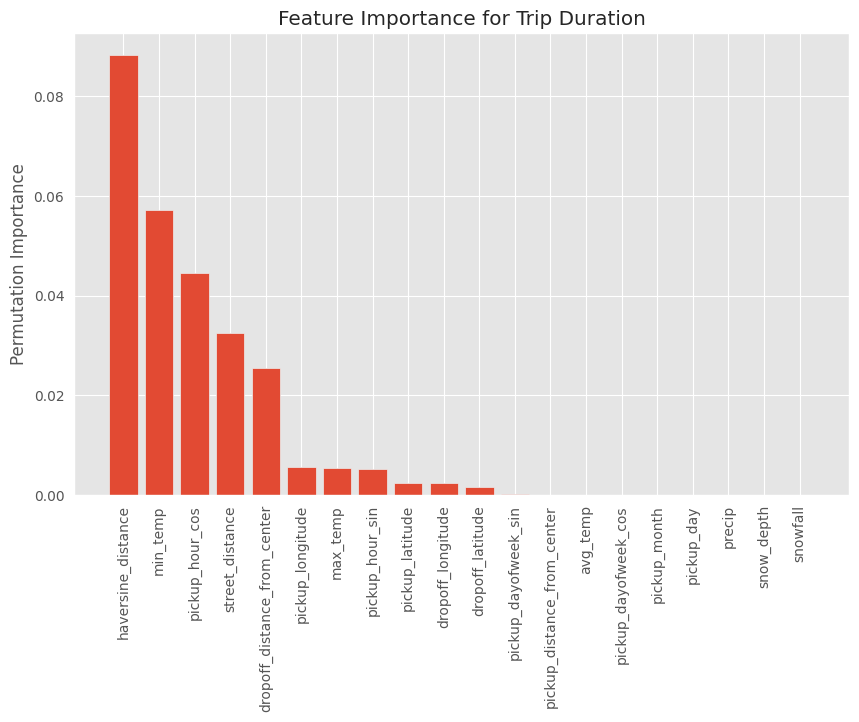

In [79]:
import matplotlib.pyplot as plt

imp_values = result.importances_mean
sorted_idx = np.argsort(imp_values)[::-1]  # descending order

plt.figure(figsize=(10,6))
plt.bar([feature_columns[i] for i in sorted_idx], imp_values[sorted_idx])
plt.xticks(rotation=90)
plt.ylabel("Permutation Importance")
plt.title("Feature Importance for Trip Duration")
plt.show()


Obviously the actual distance (haversine_distance) makes the most change in time. It doesn't look like weather changes the time spent really, although based on how cold it is (min temp), it looks like it has an affect as well. Perhaps because if it's colder or hotter, people will take the taxi?

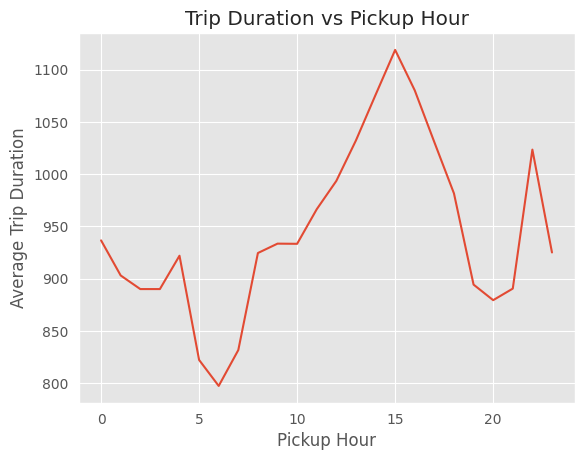

In [80]:
import matplotlib.pyplot as plt

hourly_avg = train.groupby('pickup_hour')['trip_duration'].mean()
plt.plot(hourly_avg.index, hourly_avg.values)
plt.xlabel("Pickup Hour")
plt.ylabel("Average Trip Duration")
plt.title("Trip Duration vs Pickup Hour")
plt.show()


## Hyperparameter tuning: Train models with different

In [75]:
hyperparams = {
    'learning_rate': [0.01, 0.05],
    'max_iter': [500, 1000],
    'max_depth': [5, 7, None],
    'min_samples_leaf': [10, 20],
    'l2_regularization': [0.1, 1, 10],
    'max_leaf_nodes': [63, 127],
    'max_bins': [255],
}

base_model = HistGradientBoostingRegressor(
    random_state=39,
    early_stopping=True,
    validation_fraction=0.2,
    scoring='loss'
)

random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=hyperparams,
    n_iter=5,
    scoring='neg_root_mean_squared_error',
    cv=3,
    n_jobs=-1,
    random_state=39,
    verbose=2
)

#fit the random search
print("Currently tuning hyperparameters. Sit tight...")
random_search.fit(X_train, y_train)



Currently tuning hyperparameters. Sit tight...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


ValueError: 
All the 15 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py", line 538, in fit
    X, known_categories = self._preprocess_X(X, reset=True)
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py", line 274, in _preprocess_X
    X = validate_data(self, X, **check_X_kwargs)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py", line 2944, in validate_data
    out = check_array(X, input_name="X", **check_params)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py", line 1055, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/_array_api.py", line 839, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pandas/core/generic.py", line 2153, in __array__
    arr = np.asarray(values, dtype=dtype)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string to float: 'T'


**Stats**

In [23]:
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Cross-Validation Score: {random_search.best_score_}")

#Get the best model
best_model = random_search.best_estimator_

y_val_pred = best_model.predict(X_val)

val_rmse = np.sqrt(mean_squared_error(y_test, y_val_pred))
print(f"Validation RMSE: {val_rmse}")

Best Parameters: {'min_samples_leaf': 10, 'max_leaf_nodes': 63, 'max_iter': 1000, 'max_depth': 5, 'max_bins': 255, 'learning_rate': 0.05, 'l2_regularization': 10}
Best Cross-Validation Score: -1.0205344682080486
Validation RMSE: 0.6116071522113363
